In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# 임베딩

In [ ]:
#매번 원핫인코딩, linear 처리를 하려니 귀찮다... 근데 embedding layer는 한번에 해준다
#원래 방식
torch.manual_seed(43052)
x= torch.tensor([0,1,2,0,1])
e1 = torch.nn.functional.one_hot(x).float()
l1 = torch.nn.Linear(in_features = 3, out_features = 1, bias = False) #3개의 범주형 자료에서 특성을 2개씩..
l1(e1) #이런느낌으로 했었지

tensor([[-0.2002],
        [-0.4890],
        [ 0.2081],
        [-0.2002],
        [-0.4890]], grad_fn=<MmBackward0>)

순서가,,\
X -> 원핫 인코딩 E1 -> Linear Layer에 삽입

In [ ]:
l1.weight #같다는 것을 사용하기 위해 가중치를 가져올 것임

Parameter containing:
tensor([[-0.2002, -0.4890,  0.2081]], requires_grad=True)

In [ ]:
#### 임베딩 레이어 사용
torch.manual_seed(43052)
x = torch.tensor([0,1,2,0,1])
ebdd = torch.nn.Embedding(3,1)
ebdd.weight.data = l1.weight.data.T
ebdd(x)

tensor([[-0.2002],
        [-0.4890],
        [ 0.2081],
        [-0.2002],
        [-0.4890]], grad_fn=<EmbeddingBackward0>)

In [ ]:
l1.weight.data , ebdd.weight.data #l1은 가로,, ebdd는 세로... 왜 세로인지는 원핫*가중치 꼴이라... (n,3)@(3,1) 이어야 하니깐..

(tensor([[-0.2002, -0.4890,  0.2081]]),
 tensor([[-0.2002],
         [-0.4890],
         [ 0.2081]]))

임베딩 레이어 말고 그냥 원핫인코딩을 안하고 linear layer를 사용하면 되는 것 아닌가요? 에 대한 반박\
`Answer:` 아니다... linear layer는 하나의 숫자를 바꾸면 그에 대응되는 모든 예측값이 달라진다.. 근데 Embedding 기법을 활용하면 다른 숫자들의 예측값을 바꾸지 않으면서 계산이 가능하다.자세한 설명은 강의노트 참조.

### MF-based 추천 시스템 재설계

In [ ]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [ ]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

#매핑까지는 그대로 유효함

In [ ]:
#임베딩 레이어를 활용해서 MF-based 추천 시스템을 설계하라..
torch.manual_seed(43052)
ebdd_1 = torch.nn.Embedding(9,2) #9명의 여자, 2개의 특징
ebdd_2 = torch.nn.Embedding(8,2) #8명의 남자, 2개의 특징
b1 = torch.nn.Embedding(9,1) #절편도 임베딩
b2 = torch.nn.Embedding(8,1)

In [ ]:
ebdd_1(X1).shape , ebdd_2(X2).shape

(torch.Size([63, 2]), torch.Size([63, 2]))

In [ ]:
sig = torch.nn.Sigmoid()

In [ ]:
loss_fn = torch.nn.MSELoss()
params = list(ebdd_1.parameters()) + list(ebdd_2.parameters()) + list(b1.parameters()) + list(b2.parameters())
optimizr = torch.optim.Adam(params,lr=0.1)

In [ ]:
for epoc in range(100):
  ##1
  W_features = ebdd_1(X1)
  M_features = ebdd_2(X2)
  W_bias = b1(X1)
  M_bias = b2(X2)
  score = (W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias
  yhat = sig(score)*5 #눌러서 0~ 5 사이로 맞추기
  ##2
  loss = loss_fn(yhat, y)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [ ]:
torch.concat([yhat,y],axis = 1)[::4] #굿..

tensor([[3.8397, 4.0200],
        [1.1495, 1.1200],
        [3.7054, 3.9900],
        [0.8629, 0.9600],
        [3.8186, 4.0500],
        [0.9267, 0.9900],
        [0.5782, 0.5600],
        [0.7948, 1.1200],
        [4.0900, 4.1600],
        [0.7469, 1.0500],
        [3.8631, 3.7800],
        [0.7221, 0.8800],
        [3.9170, 4.0400],
        [0.5869, 1.0300],
        [4.9622, 4.8500],
        [4.9768, 4.3900]], grad_fn=<SliceBackward0>)

# 사용자 정의 네트워크

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)

In [ ]:
X = torch.randn(5,1)

In [ ]:
net(X)

tensor([[0.3901],
        [0.3808],
        [0.4083],
        [0.4362],
        [0.3854]], grad_fn=<SigmoidBackward0>)

In [ ]:
net.forward(X) #foward 아니라 forward 입니다만..

tensor([[0.3901],
        [0.3808],
        [0.4083],
        [0.4362],
        [0.3854]], grad_fn=<SigmoidBackward0>)

net(X) 와 net.forward(X)가 기능이 같으므로 forward의 기능을 수정하면 network 출력 결과를 수정할 수 있다.

In [ ]:
net.forward = lambda x : print('메롱')

In [ ]:
net.forward(X)

메롱


In [ ]:
net(X) #뭘 넣어도 이제 메롱만 나옴

메롱


In [ ]:
class Mynet1(torch.nn.Module): #고정(이름 원하는거 설정 가능)
  def __init__(self): #고정
    super().__init__() #고정
    self.l1 = torch.nn.Linear(in_features = 1, out_features = 1, bias = True)
    self.a1 = torch.nn.Sigmoid()
    self.l2 = torch.nn.Linear(in_features = 1, out_features = 1, bias = False)
  def forward(self,x): #self는 무조건 들어가고 그 다음에 입력값 제시
    yhat = self.l2(self.a1(self.l1(x)))
    return yhat #return 까먹지 마세요

In [ ]:
net = Mynet1() # 네트워크 객체 생성

In [ ]:
x = torch.randn(5,1)

In [ ]:
net(x)

tensor([[0.1406],
        [0.1435],
        [0.3341],
        [0.2488],
        [0.2071]], grad_fn=<MmBackward0>)

In [ ]:
#사용자 지정 네트워크를 사용해서 예제를 풀어보자.
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
x = x.reshape(-1,1)
ϵ = torch.randn(100).reshape(-1,1)*0.5
y = 2.5+ 4*x + ϵ

In [ ]:
class Mynet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = torch.nn.Linear(1,1)
  def forward(self,x):
    yhat = self.l1(x)
    return yhat

In [ ]:
net = Mynet()

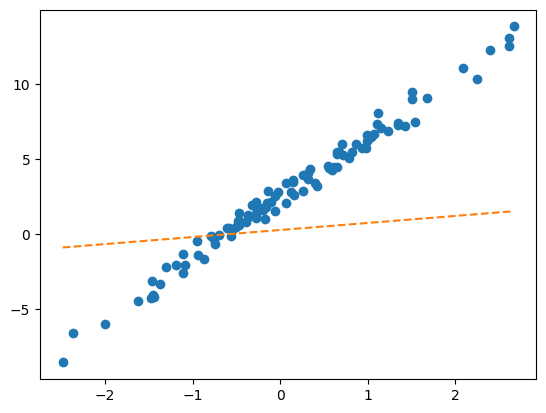

In [ ]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--')

In [ ]:
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(), lr = 0.1)

In [ ]:
#학습 시작
for i in range(40):
  ##1
  yhat = net(x)
  ##2
  loss = loss_fn(yhat, y)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

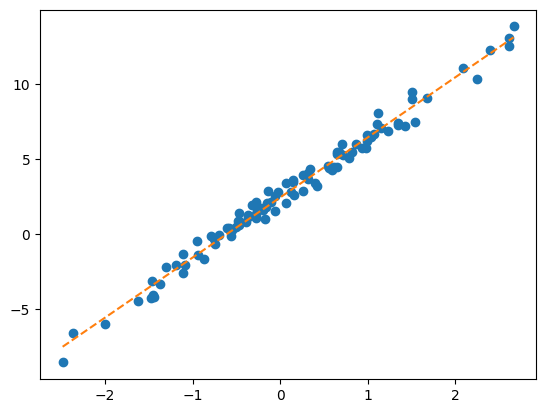

In [ ]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--') #학습 잘 되었음.. 에폭 40번으로 한 이유는 초기값이 좀 안맞아서 ㄴ

# 추천시스템을 사용자 정의 네트워크를 활용하여 학습해보자.

In [ ]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view #주어진 데이터 프레임

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [ ]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

## 풀이 1 , 입력을 각각 X1, X2로 받는 경우

In [ ]:
class Mynet1(torch.nn.Module):
  def __init__(self):
    super().__init__() #외워!!!
    self.ebdd1 = torch.nn.Embedding(9,2)
    self.b1 = torch.nn.Embedding(9,1)
    self.ebdd2 = torch.nn.Embedding(8,2)
    self.b2 = torch.nn.Embedding(8,1)
    self.sig = torch.nn.Sigmoid()
  def forward(self,x1,x2):
    W_feature = self.ebdd1(x1)
    W_bias = self.b1(x1)
    M_feature = self.ebdd2(x2)
    M_bias = self.b2(x2)
    score = (W_feature*M_feature).sum(axis =1).reshape(-1,1) + W_bias + M_bias
    yhat = sig(score)*5
    return yhat

In [ ]:
net = Mynet1()

In [ ]:
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(), lr = 0.1)

In [ ]:
#학습 시작..
for epoc in range(100):
  ##1
  yhat = net(X1,X2)
  ##2
  loss = loss_fn(yhat,y)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [ ]:
torch.concat([yhat,y],axis=1)[::5]

tensor([[3.7108, 4.0200],
        [0.5786, 0.4300],
        [3.8272, 3.4300],
        [3.6074, 3.4200],
        [0.8645, 0.9900],
        [0.6888, 0.5200],
        [0.6139, 0.4300],
        [0.8594, 0.9400],
        [3.6652, 3.7800],
        [0.5782, 0.8900],
        [0.6006, 0.4800],
        [3.7162, 3.8200],
        [4.4149, 4.3900]], grad_fn=<SliceBackward0>)

## 풀이2, 입력을 X 하나로

In [ ]:
X = torch.stack([X1,X2],axis=1) #하나의 X

In [ ]:
X[:,1]

tensor([1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 6, 7, 0, 1, 3,
        4, 5, 6, 7, 0, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 7, 0, 1, 2, 3, 4, 5,
        6, 7, 0, 1, 2, 4, 5, 6, 0, 1, 3, 4, 5, 6, 7])

In [ ]:
class Mynet2(torch.nn.Module):
  def __init__(self): #__init__self() 라고 잘못 써버림..
    super().__init__()
    self.ebdd1 = torch.nn.Embedding(9,2)
    self.ebdd2 = torch.nn.Embedding(8,2)
    self.b1 = torch.nn.Embedding(9,1)
    self.b2 = torch.nn.Embedding(8,1)
    self.sig = torch.nn.Sigmoid()
  def forward(self,X):
    X1,X2  = X[:,0], X[:,1]
    W_features = self.ebdd1(X1)
    M_features = self.ebdd2(X2)
    W_bias = self.b1(X1)
    M_bias = self.b2(X2)
    score = (W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias
    yhat = sig(score)*5
    return yhat

In [ ]:
net1 = Mynet2()

In [ ]:
#loss_fn 그대로 쓰고
optimizr = torch.optim.Adam(net1.parameters(),lr=0.1) # 이게 편해요!!

In [ ]:
for epoc in range(200):
  ##1
  yhat = net1(X)
  ##2
  loss = loss_fn(yhat,y)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [ ]:
torch.concat([yhat,y],axis =1 )[::6] #굿.

tensor([[4.0702, 4.0200],
        [0.5906, 0.4900],
        [0.9579, 0.9600],
        [0.5167, 0.3900],
        [0.5054, 0.5600],
        [0.4861, 0.4300],
        [0.9980, 1.0500],
        [0.5050, 0.5100],
        [3.9793, 4.0400],
        [3.8061, 4.0000],
        [4.6220, 4.3900]], grad_fn=<SliceBackward0>)

NN-based 추천 시스템

In [ ]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [ ]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

In [ ]:
class Mynet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.ebdd1 = torch.nn.Embedding(9,2)
    self.ebdd2 = torch.nn.Embedding(8,2)
    self.b1 = torch.nn.Embedding(9,1)
    self.b2 = torch.nn.Embedding(8,1)
    self.mlp = torch.nn.Sequential(
        torch.nn.Linear(6,1), #6개의 feature들?
        torch.nn.Sigmoid()
    )
  def forward(self,X1,X2):
    W_features = self.ebdd1(X1)
    W_bias = self.b1(X1)
    M_features = self.ebdd2(X2)
    M_bias = self.b1(X2)
    Z= torch.concat([W_features, M_features, W_bias, M_bias],axis = 1)
    output = self.mlp(Z) * 5

    return output

In [ ]:
net = Mynet() #인스턴스 생성

In [ ]:
net(X1,X2).shape #디멘션 확인.. 잘 되는 듯?

torch.Size([63, 1])

In [ ]:
list(net.parameters()) #계수들이 잘 들어가 있군

[Parameter containing:
 tensor([[ 0.1655, -0.2754],
         [ 0.8340,  1.1406],
         [ 0.4594,  1.3465],
         [ 0.6232, -1.5994],
         [ 0.3902,  0.7739],
         [ 0.4044,  0.1994],
         [ 1.0364,  0.2928],
         [ 0.7936, -1.6664],
         [-0.6989, -0.2884]], requires_grad=True),
 Parameter containing:
 tensor([[-0.2052,  0.1526],
         [-2.0027,  1.6797],
         [-0.8590,  0.7495],
         [-1.0475,  1.1064],
         [-0.4312,  1.3069],
         [-1.4557,  0.4616],
         [-0.2599, -0.2777],
         [ 0.0607,  0.8679]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1542],
         [-0.8426],
         [ 1.5376],
         [-1.1171],
         [-0.1345],
         [ 0.5018],
         [-0.9318],
         [ 0.0596],
         [ 1.0783]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3074],
         [-0.1037],
         [-1.2362],
         [-0.1316],
         [ 0.9993],
         [ 0.0849],
         [-1.1911],
         [ 0.3548]], requires

In [ ]:
#옵티마이저 , 손실함수 정의
optimizr = torch.optim.SGD(net.parameters(),lr = 0.1)
loss_fn = torch.nn.MSELoss()

In [ ]:
for epoc in range(200):
  ##1
  yhat = net(X1,X2)
  ##2
  loss = loss_fn(yhat,y)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [ ]:
torch.concat([yhat,y],axis=1)[::6] #? 학습이 안됐네??

tensor([[2.3299, 4.0200],
        [1.7871, 0.4900],
        [2.6867, 0.9600],
        [2.4598, 0.3900],
        [1.9098, 0.5600],
        [2.6608, 0.4300],
        [2.3532, 1.0500],
        [2.0524, 0.5100],
        [2.0750, 4.0400],
        [2.4456, 4.0000],
        [4.6847, 4.3900]], grad_fn=<SliceBackward0>)

In [ ]:
#깊은 신경망으로 해결할 수 있을 듯
class Mynet2(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.ebdd1 = torch.nn.Embedding(9,2)
    self.ebdd2 = torch.nn.Embedding(8,2)
    self.b1 = torch.nn.Embedding(9,1)
    self.b2 = torch.nn.Embedding(8,1)
    self.mlp = torch.nn.Sequential(
        torch.nn.Linear(6,15), #레이어를 두겹으로 만들었음 (깊은 신경망)
        torch.nn.ReLU(),
        torch.nn.Linear(15,15),
        torch.nn.ReLU(),
        torch.nn.Linear(15,1),
        torch.nn.Sigmoid()
    )
  def forward(self,X1,X2):
    W_features = self.ebdd1(X1)
    W_bias = self.b1(X1)
    M_features = self.ebdd2(X2)
    M_bias = self.b1(X2)
    Z= torch.concat([W_features, M_features, W_bias, M_bias],axis = 1)
    yhat = self.mlp(Z) * 5

    return yhat


In [ ]:
net2 = Mynet2()

In [ ]:
net2(X1,X2).shape #원하는 결과를 뽑아 낼 수 있을 것으로 기대됨..

torch.Size([63, 1])

In [ ]:
#옵티마이저 , 손실함수 정의
optimizr = torch.optim.Adam(net2.parameters(),lr = 0.1)
loss_fn = torch.nn.MSELoss()

for epoc in range(1000):
  ##1
  yhat = net2(X1,X2)
  ##2
  loss = loss_fn(yhat,y)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [ ]:
torch.concat([yhat,y],axis = 1)[::5] #훨씬 낫군 ㅎㅎ

tensor([[4.0194, 4.0200],
        [0.4422, 0.4300],
        [3.4286, 3.4300],
        [3.4230, 3.4200],
        [1.0033, 0.9900],
        [0.5201, 0.5200],
        [0.4306, 0.4300],
        [0.9418, 0.9400],
        [3.7748, 3.7800],
        [0.8897, 0.8900],
        [0.4753, 0.4800],
        [3.8136, 3.8200],
        [4.3898, 4.3900]], grad_fn=<SliceBackward0>)

In [ ]:
#옥순 - 영식 , 영자 - 다호, 하니 - 영호 예측 해보기
w , m

({'옥순(IN)': 0,
  '영자(IN)': 1,
  '정숙(IS)': 2,
  '영숙(IS)': 3,
  '순자(EN)': 4,
  '현숙(EN)': 5,
  '서연(ES)': 6,
  '보람(ES)': 7,
  '하니(I)': 8},
 {'영식(IN)': 0,
  '영철(IN)': 1,
  '영호(IS)': 2,
  '광수(IS)': 3,
  '상철(EN)': 4,
  '영수(EN)': 5,
  '규빈(ES)': 6,
  '다호(ES)': 7})

In [ ]:
XX1 = torch.tensor([0,1,8])
XX2 = torch.tensor([0,7,2])

In [ ]:
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [ ]:
net2(XX1,XX2) #Adam이 좀 더 잘 맞추긴 하네...

tensor([[3.8421],
        [0.5636],
        [4.5390]], grad_fn=<MulBackward0>)